In [90]:
# Import Statements for everything we use
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeRegressor as DTR, plot_tree)
from sklearn.metrics import r2_score


In [91]:
# Load data and check that it looks okay
houseData = pd.read_csv("./Econ424_F2023_PC2_training_set_v1.csv")
print(houseData.describe())

           LOGVALUE         BATHS        BEDRMS         BUILT        UNITSF  \
count  19999.000000  19999.000000  19999.000000  19999.000000  19999.000000   
mean      12.054003      1.915196      3.207610   1970.747587   2339.850528   
std        1.093036      0.779724      0.872225     25.543423   1969.763693   
min        0.000000      0.000000      0.000000   1919.000000     99.000000   
25%       11.512925      1.000000      3.000000   1950.000000   1400.000000   
50%       12.100712      2.000000      3.000000   1975.000000   2000.000000   
75%       12.611538      2.000000      4.000000   1990.000000   2487.000000   
max       15.476535     10.000000      8.000000   2011.000000  20159.000000   

                 LOT         ROOMS        REGION       KITCHEN        FLOORS  \
count   19999.000000  19999.000000  19999.000000  19999.000000  19999.000000   
mean    44339.419240      6.571029      2.842342      1.005350      1.931947   
std    114513.834797      1.684882      1.007669

In [92]:
# Format data as needed for the model
model = MS(houseData.columns.drop('LOGVALUE'), intercept=False) 
D = model.fit_transform(houseData)
feature_names = list(D.columns)
print(len(feature_names))
X = np.asarray(D)

13


In [93]:
# Split data into train and val, used 80-20 split since we already have 10,000 in given test set
(X_train,
X_val ,
y_train ,
y_val) = skm.train_test_split(X,
houseData['LOGVALUE'], test_size=0.2, random_state=20)

0.976407484075377

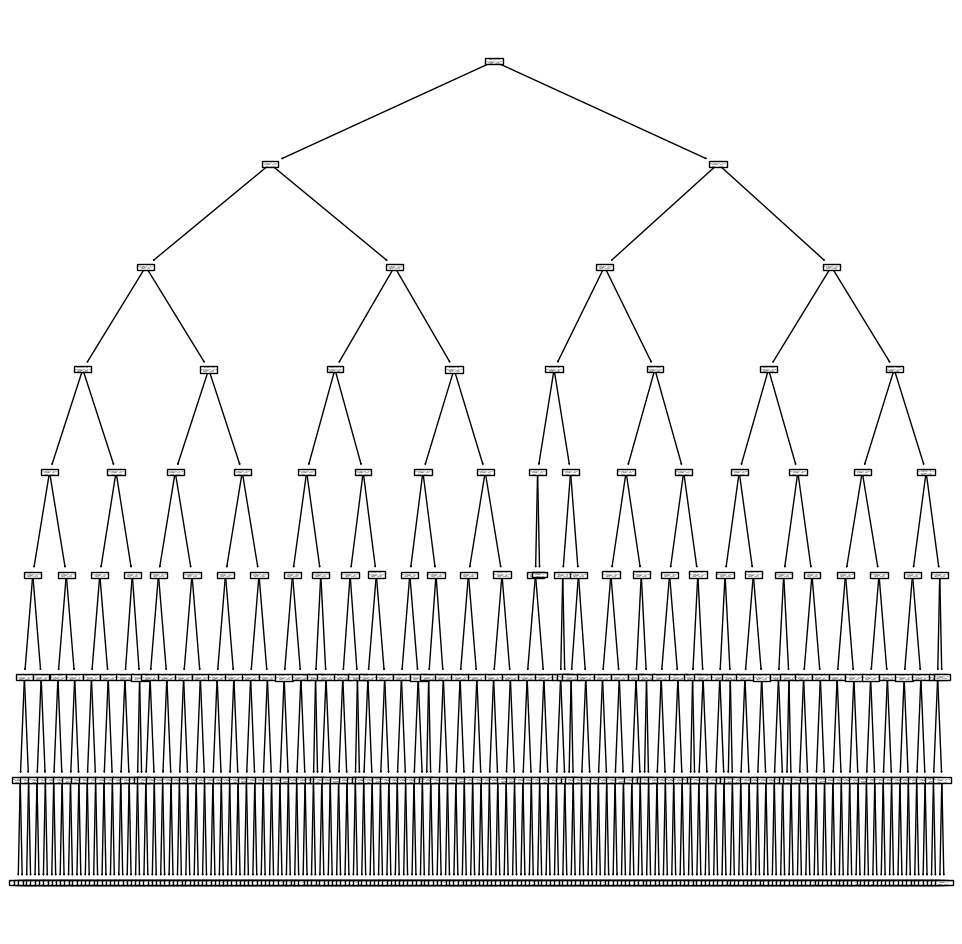

In [94]:
# Create base regression tree of depth to compare our findings with
reg = DTR(max_depth=8) 
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1] 
plot_tree(reg,feature_names=feature_names, ax=ax)
np.mean((y_val - reg.predict(X_val))**2)

In [95]:
# Apply k-fold cross validation on it to prune it
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train) 
kfold = skm.KFold(6, shuffle=True, random_state=20) 
grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

0.976407484075377
1.0116862251017777


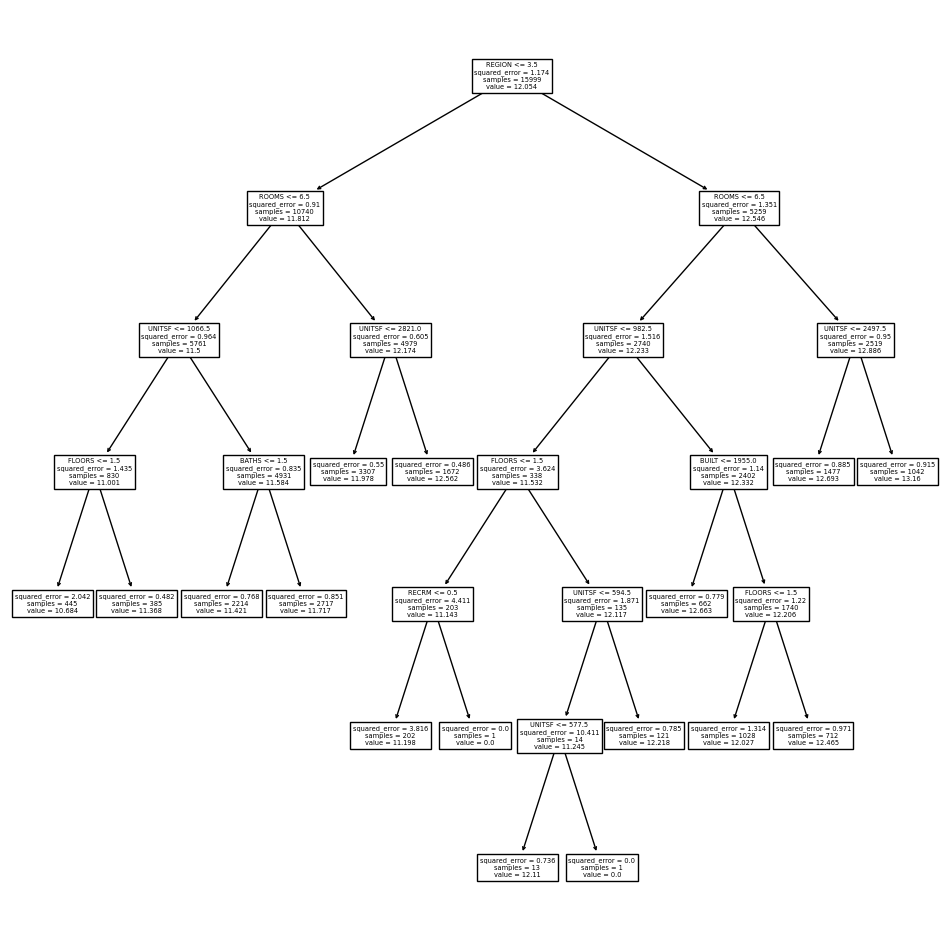

In [96]:
# Plot the pruned tree found at max_depth=8 for this dataset
best_ = grid.best_estimator_
ax = subplots(figsize=(12,12))[1] 
plot_tree(G.best_estimator_ ,feature_names=feature_names, ax=ax)

# Print the mean squared error for original regression tree vs best one from k-fold
print(np.mean((y_val - reg.predict(X_val))**2))
print(np.mean((y_val - best_.predict(X_val))**2))


1.171260085724424
1.0680200092695946
1.0107254931388698
0.9728273375716034
0.9849458375448054
0.9648734113702216
1.0065560156907998
1.0116862251017786
1.0116862251017773
1.0116862251017775
1.0065560156907998
1.011686225101778


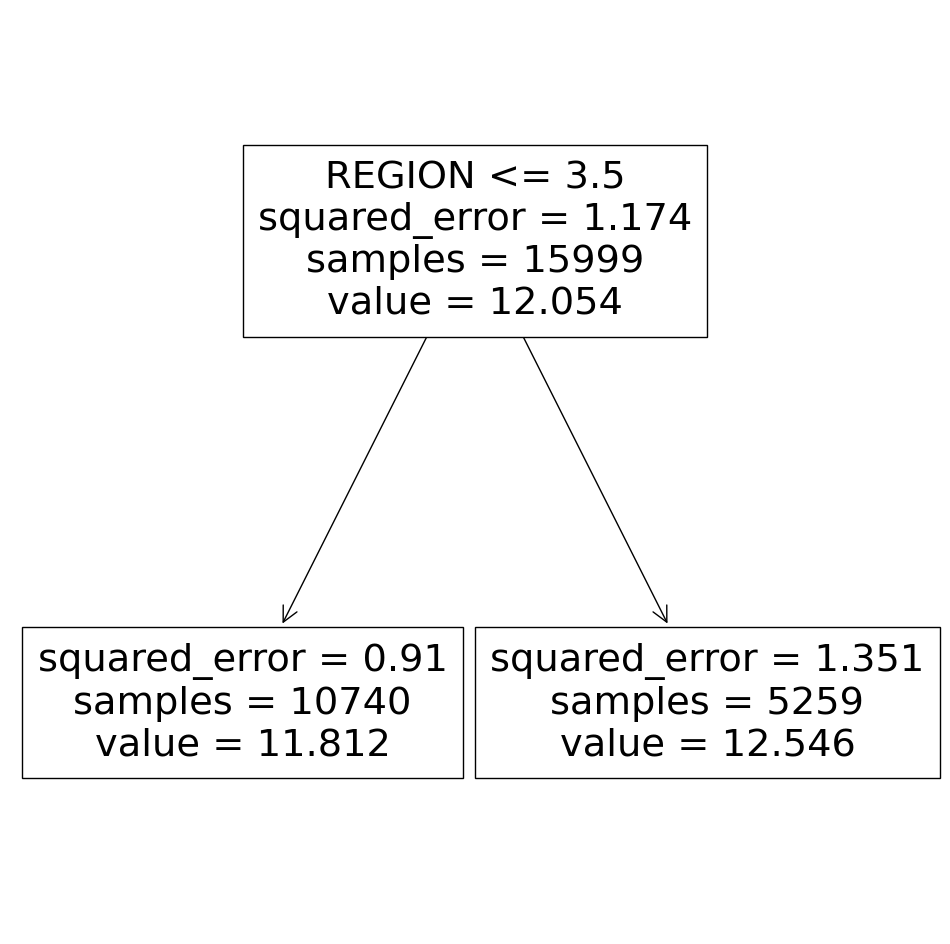

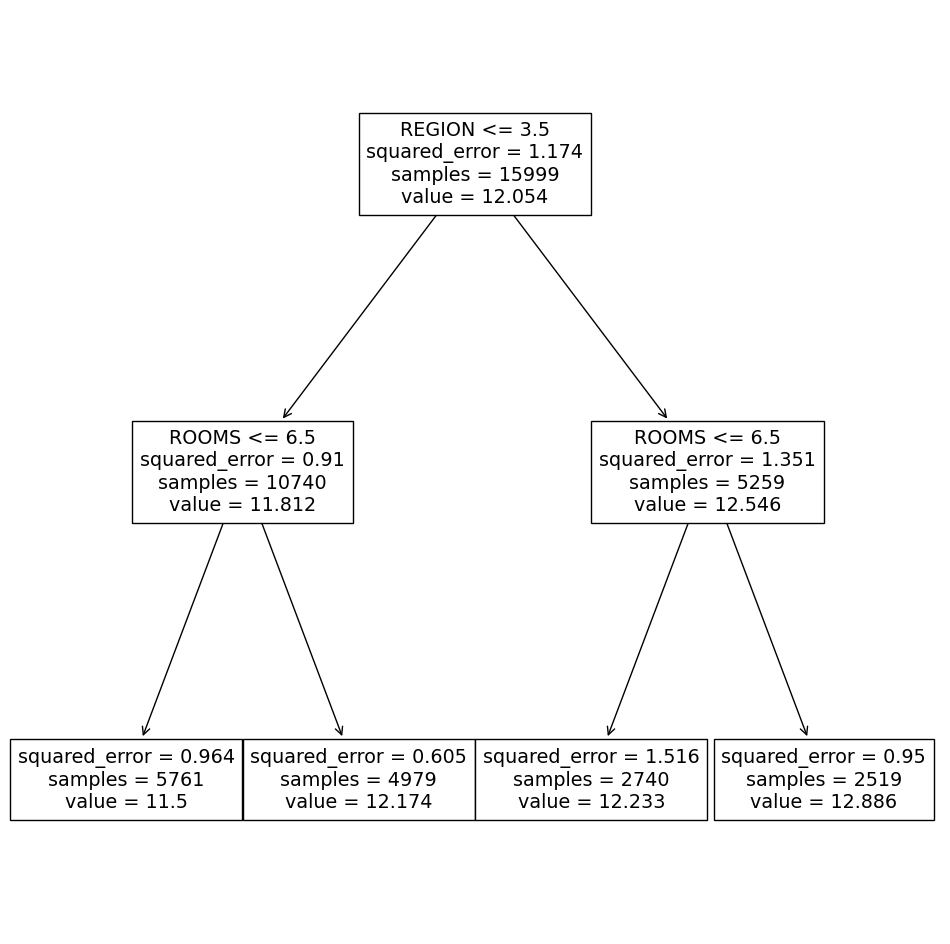

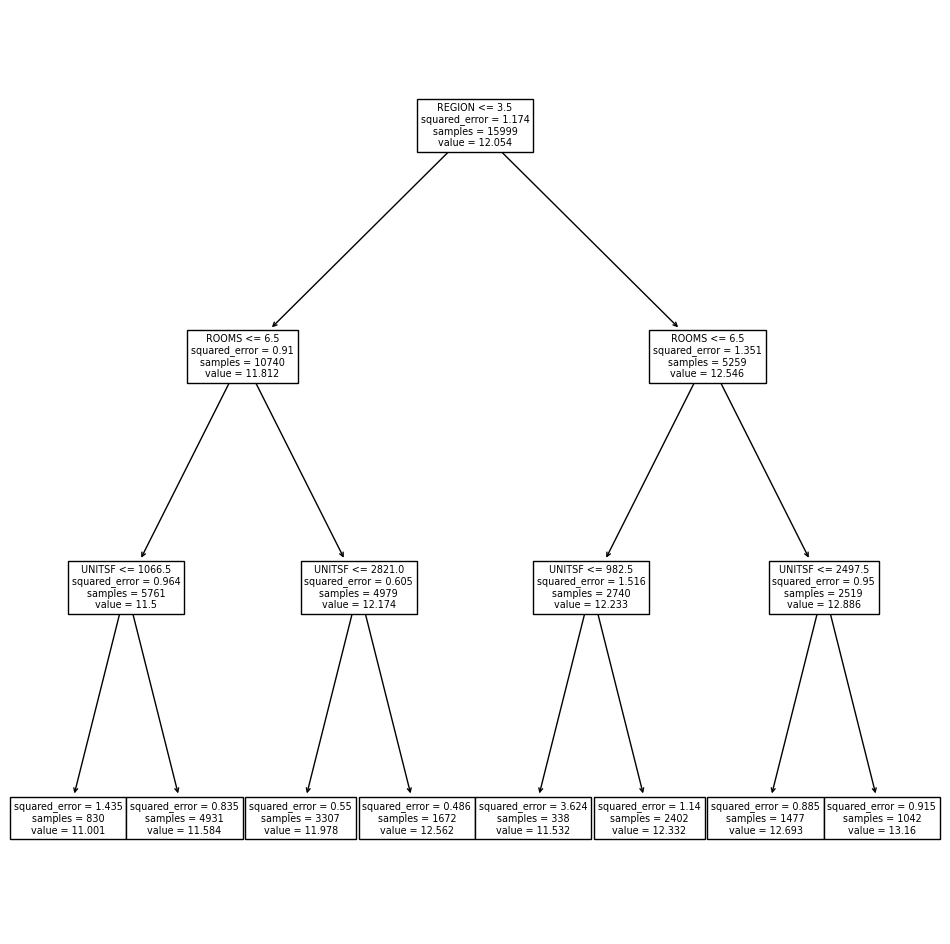

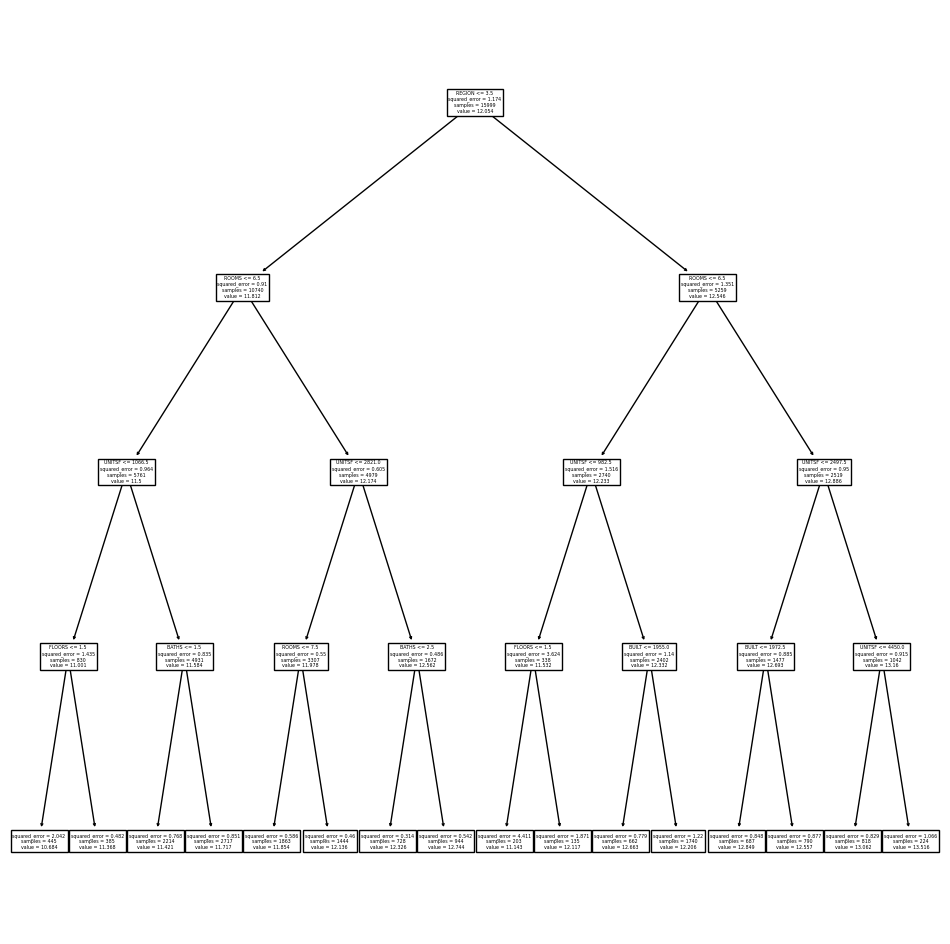

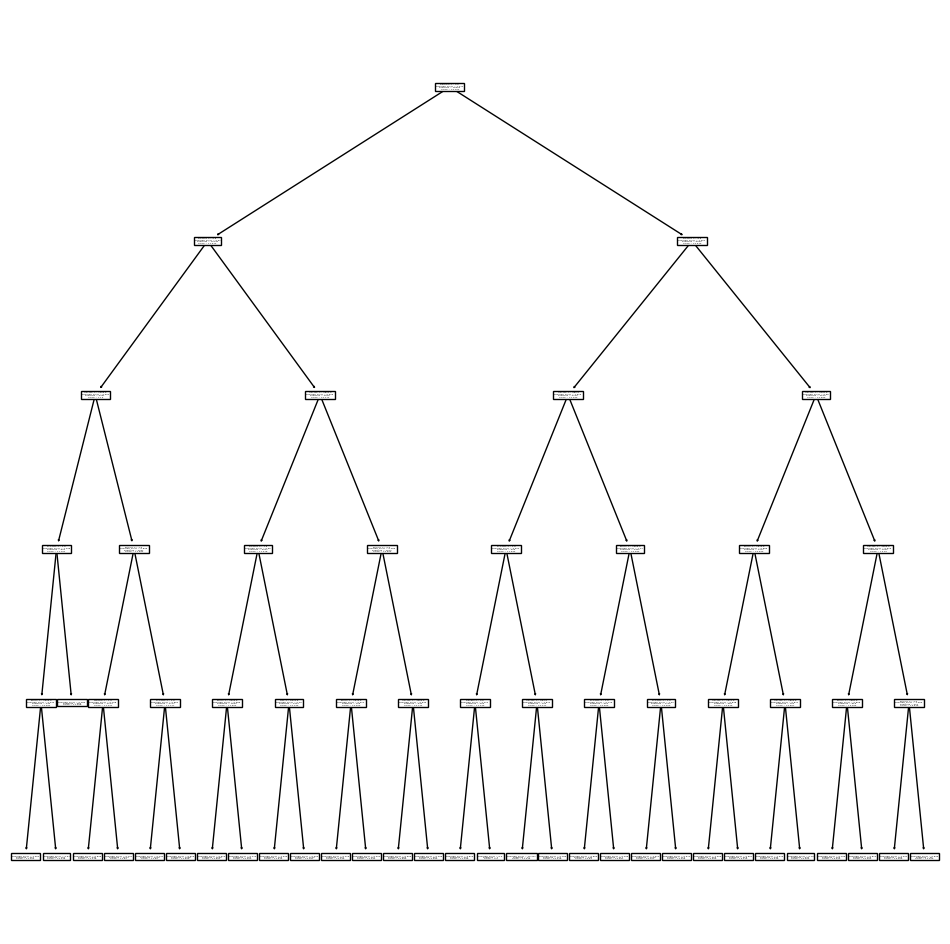

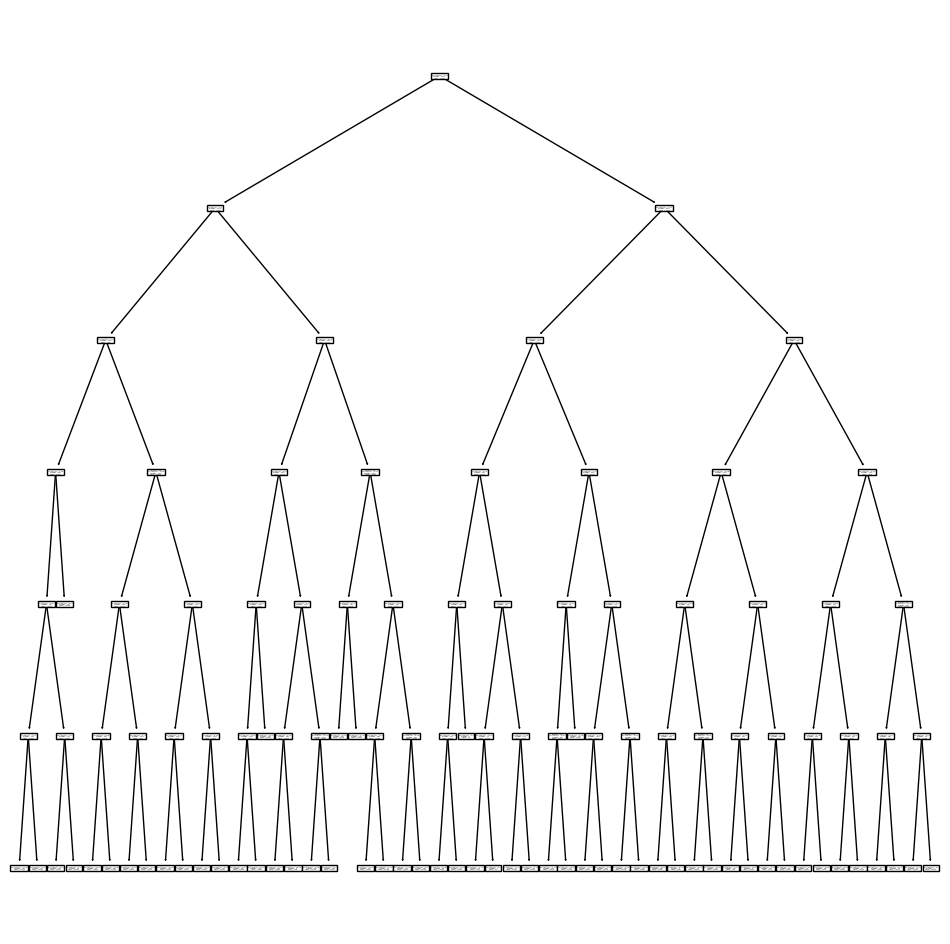

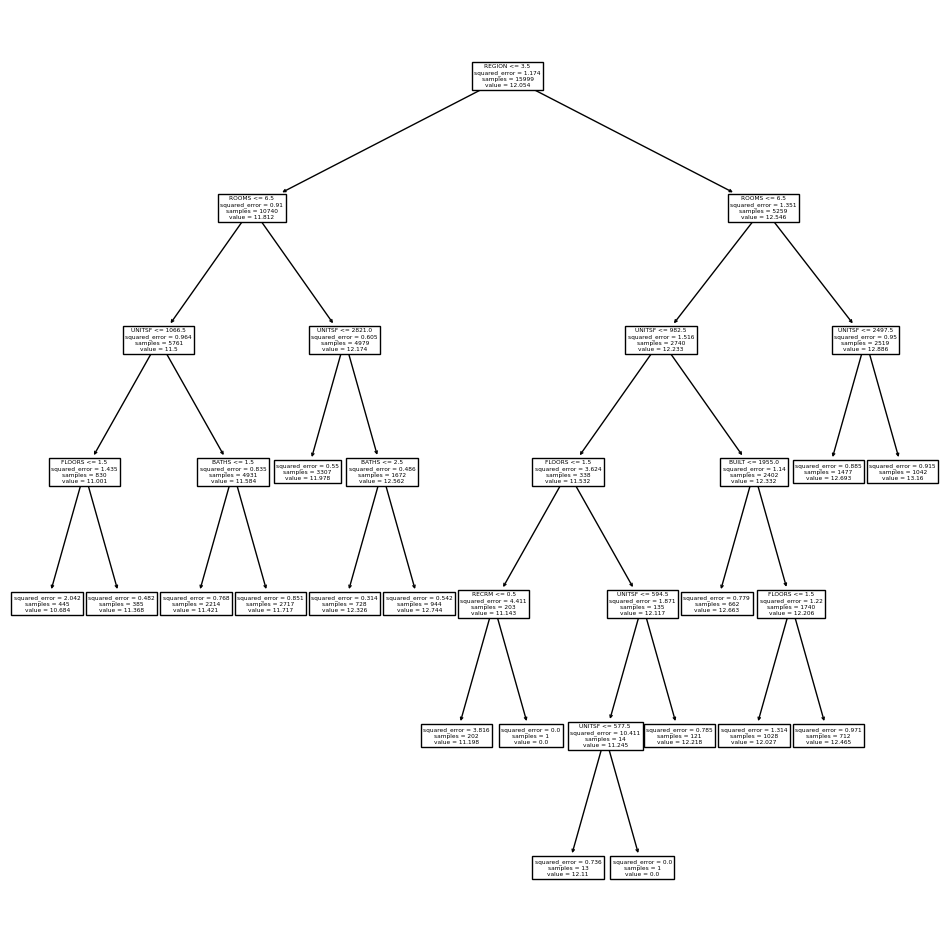

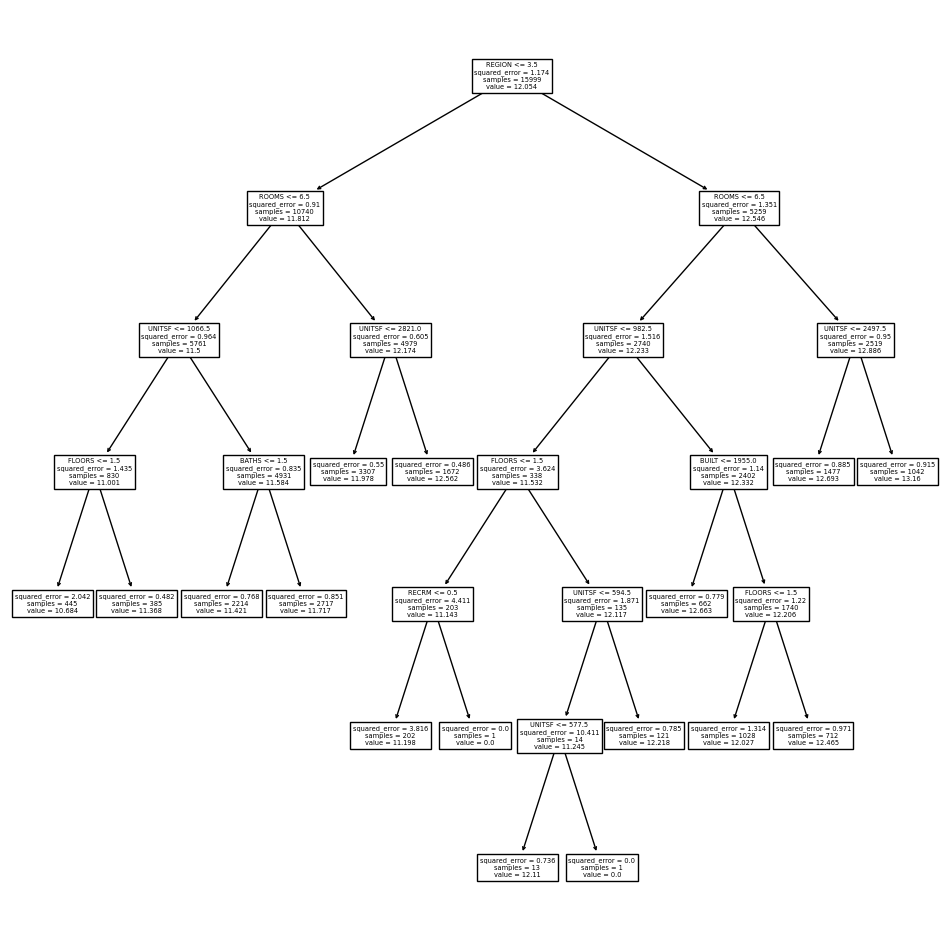

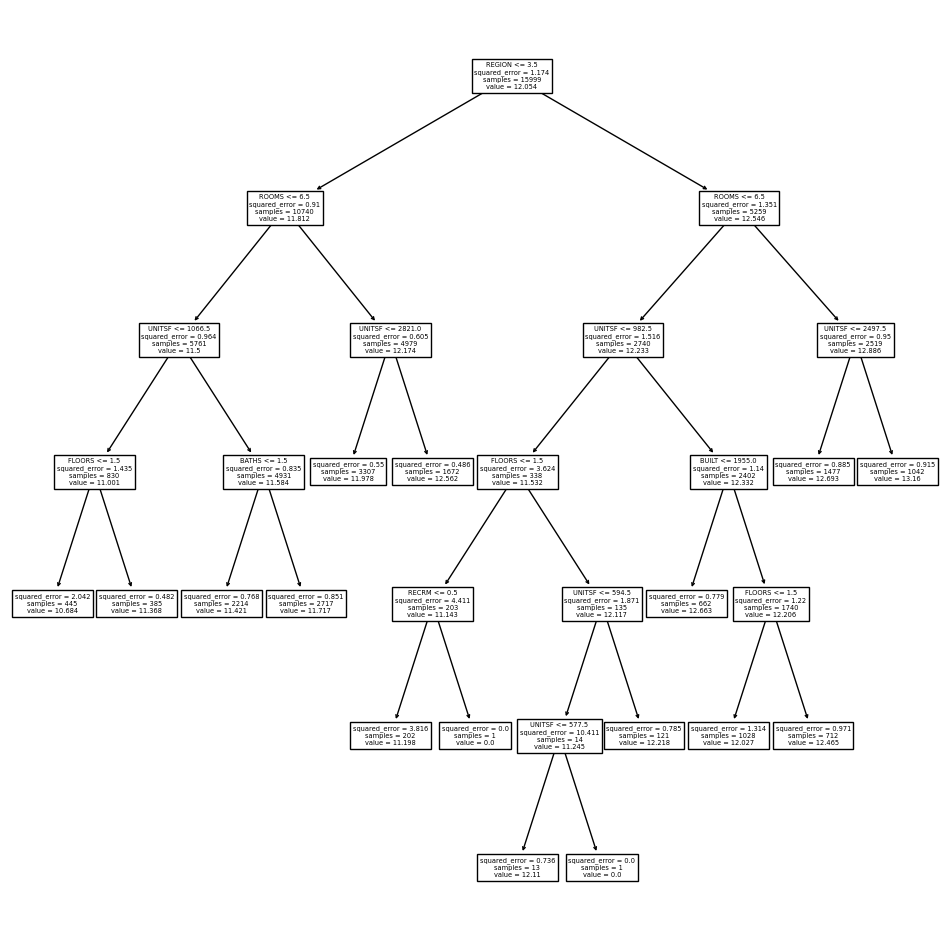

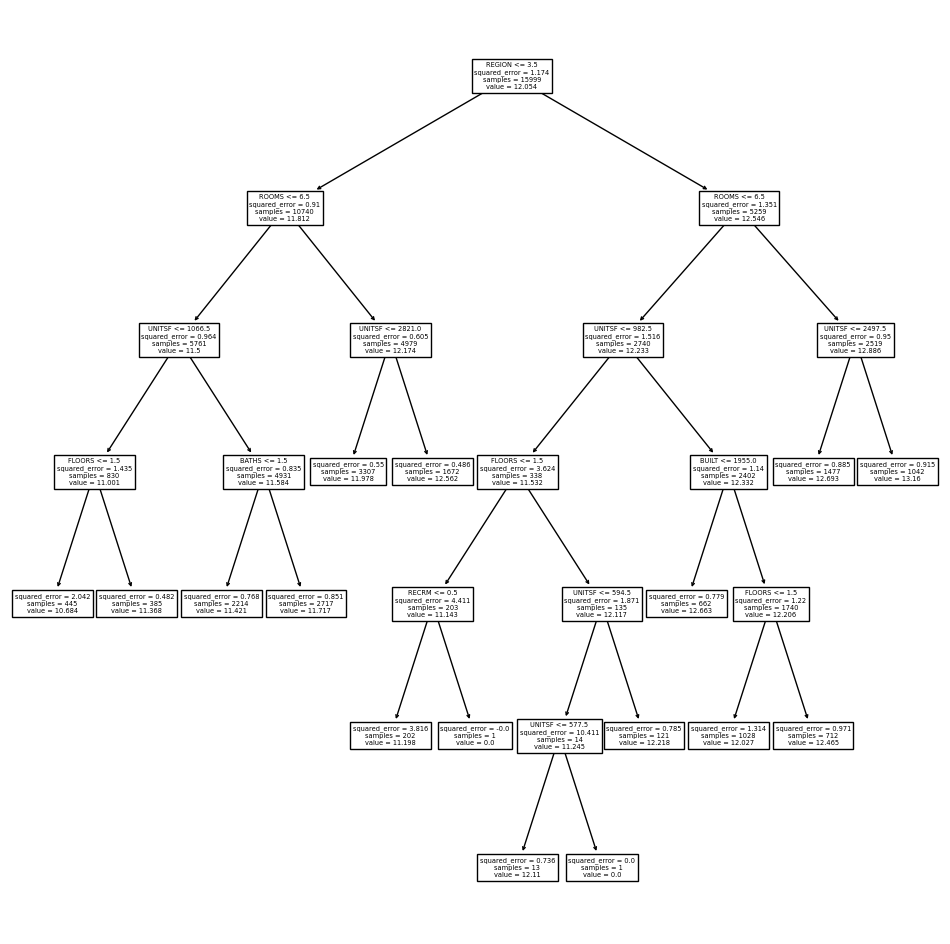

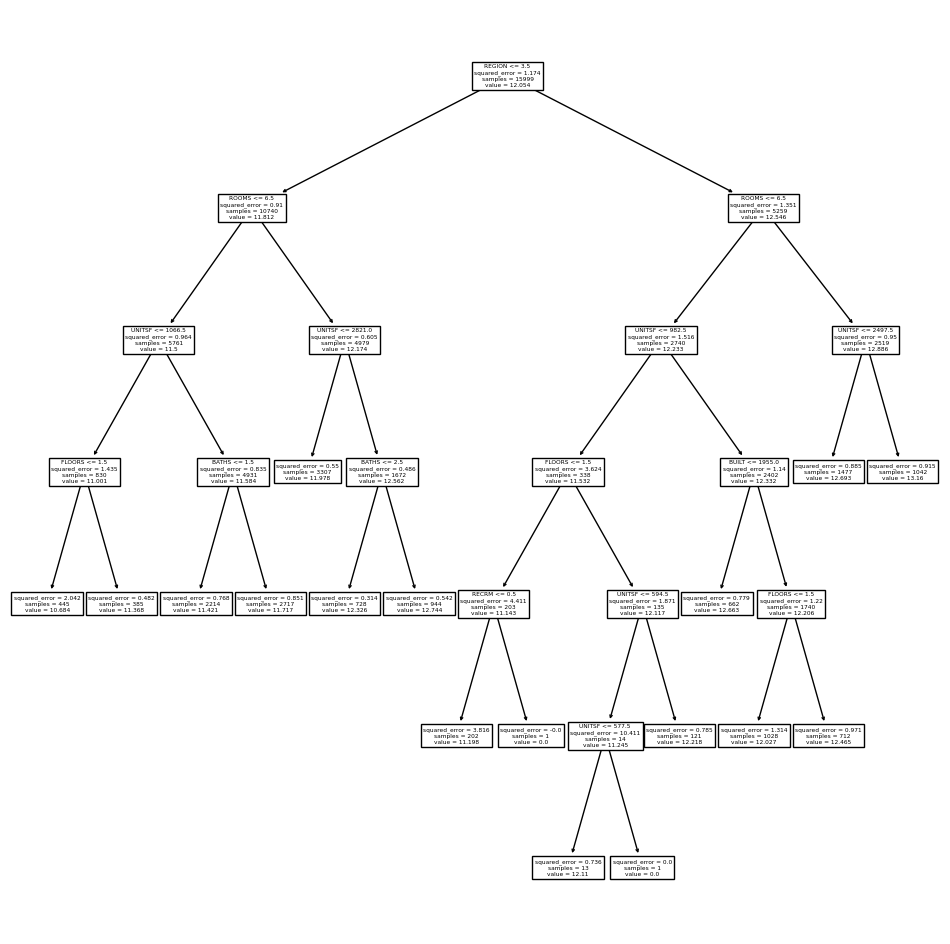

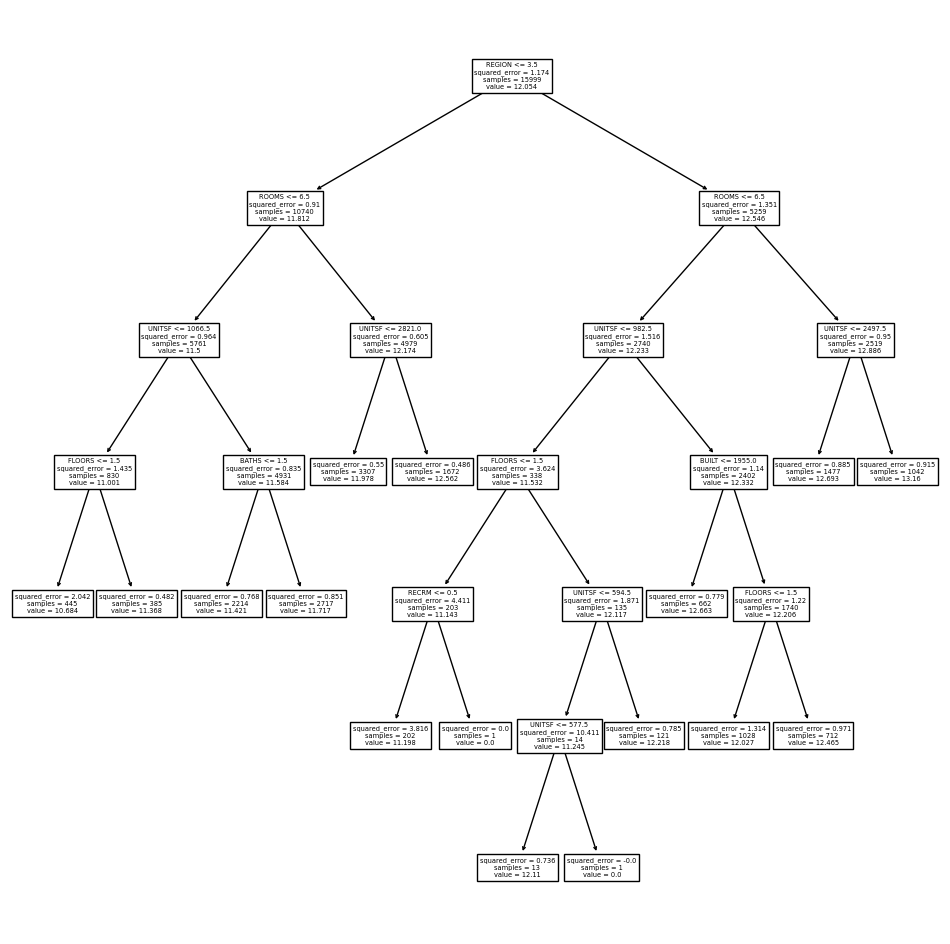

In [97]:
# General Idea:
# Loop through possible depths, create regression trees and perform cross-validation
# Take the best possible tree from all depth levels
# Plot errors across each tree depth best/pruned trees

# Track all MSE for each depth as we run the loop
depths = np.array([])
trainingMSE = np.array([])
valMSE = np.array([])
kFoldMSE = np.array([])

# Initialize a best estimator found so far
bestKFold_MSE = np.mean((y_val - best_.predict(X_val))**2)
bestEstimator = best_
bestDepth = bestEstimator.get_depth()

# Loop through all possible depths
for depth in range(1,13):
    # Make a regression tree for current depth
    reg = DTR(max_depth=depth) 
    reg.fit(X_train, y_train)
    
    # Use unpruned tree to make predictions on train and val set
    mse_reg_val = np.mean((y_val - reg.predict(X_val))**2)
    mse_reg_train = np.mean((y_train - reg.predict(X_train))**2)
    
    # Apply k-fold cross-validation to find best pruned tree
    ccp_path = reg.cost_complexity_pruning_path(X_train, y_train) 
    kfold = skm.KFold(5, shuffle=True, random_state=20) 
    grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')
    G = grid.fit(X_train, y_train)
    
    # Best pruned tree for current depth after cross validation
    currBest = grid.best_estimator_
    currMSE = np.mean((y_val-currBest.predict(X_val))**2)
    print(currMSE)
    
    # Append prediction accuracies to the relative arrays
    depths = np.append(depths, depth)
    kFoldMSE = np.append(kFoldMSE, currMSE)
    valMSE = np.append(valMSE, mse_reg_val)
    trainingMSE = np.append(trainingMSE, mse_reg_train)
    
    # Plot the best pruned tree found at each depth level
    ax = subplots(figsize=(12,12))[1] 
    plot_tree(currBest,feature_names=feature_names, ax=ax)
    
    
    # compare with best mse seen so far, if better, update it
    if currMSE < bestKFold_MSE:
        # save new max MSE 
        bestKFold_MSE = currMSE
        # save best tree
        bestEstimator = currBest
    
   
    

In [98]:
# Make our predictions on the entire training dataset
y_pred = bestEstimator.predict(X)
# Calculate MSE
outputMSE = np.mean((houseData["LOGVALUE"] - y_pred)**2)
# Calculate R Squared
outputRSquared = r2_score(houseData["LOGVALUE"], y_pred)

# Print them
print("Output MSE is: " + str(outputMSE))
print("Output R squared is: " + str(outputRSquared))

Output MSE is: 0.8115699034007182
Output R squared is: 0.32067358141626967


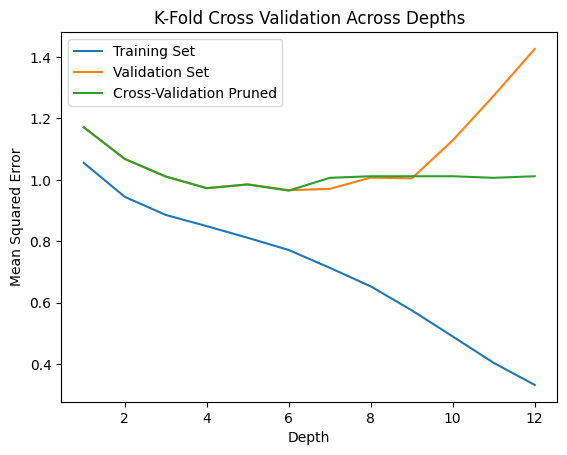

In [99]:
# Plot differences in Mean Squared Error across the different depths applying k-fold
plt.plot(depths, trainingMSE, label='Training Set')
plt.plot(depths, valMSE, label='Validation Set')
plt.plot(depths, kFoldMSE, label='Cross-Validation Pruned')
plt.xlabel("Depth")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("K-Fold Cross Validation Across Depths")
plt.show()

Best depth is at: 6


[Text(0.46200980392156865, 0.9285714285714286, 'REGION <= 3.5\nsquared_error = 1.174\nsamples = 15999\nvalue = 12.054'),
 Text(0.22058823529411764, 0.7857142857142857, 'ROOMS <= 6.5\nsquared_error = 0.91\nsamples = 10740\nvalue = 11.812'),
 Text(0.10294117647058823, 0.6428571428571429, 'UNITSF <= 1066.5\nsquared_error = 0.964\nsamples = 5761\nvalue = 11.5'),
 Text(0.049019607843137254, 0.5, 'FLOORS <= 1.5\nsquared_error = 1.435\nsamples = 830\nvalue = 11.001'),
 Text(0.0392156862745098, 0.35714285714285715, 'BUILT <= 1965.0\nsquared_error = 2.042\nsamples = 445\nvalue = 10.684'),
 Text(0.0196078431372549, 0.21428571428571427, 'ROOMS <= 4.5\nsquared_error = 1.061\nsamples = 251\nvalue = 11.024'),
 Text(0.00980392156862745, 0.07142857142857142, 'squared_error = 1.553\nsamples = 100\nvalue = 10.744'),
 Text(0.029411764705882353, 0.07142857142857142, 'squared_error = 0.65\nsamples = 151\nvalue = 11.209'),
 Text(0.058823529411764705, 0.21428571428571427, 'ROOMS <= 5.5\nsquared_error = 2.97\

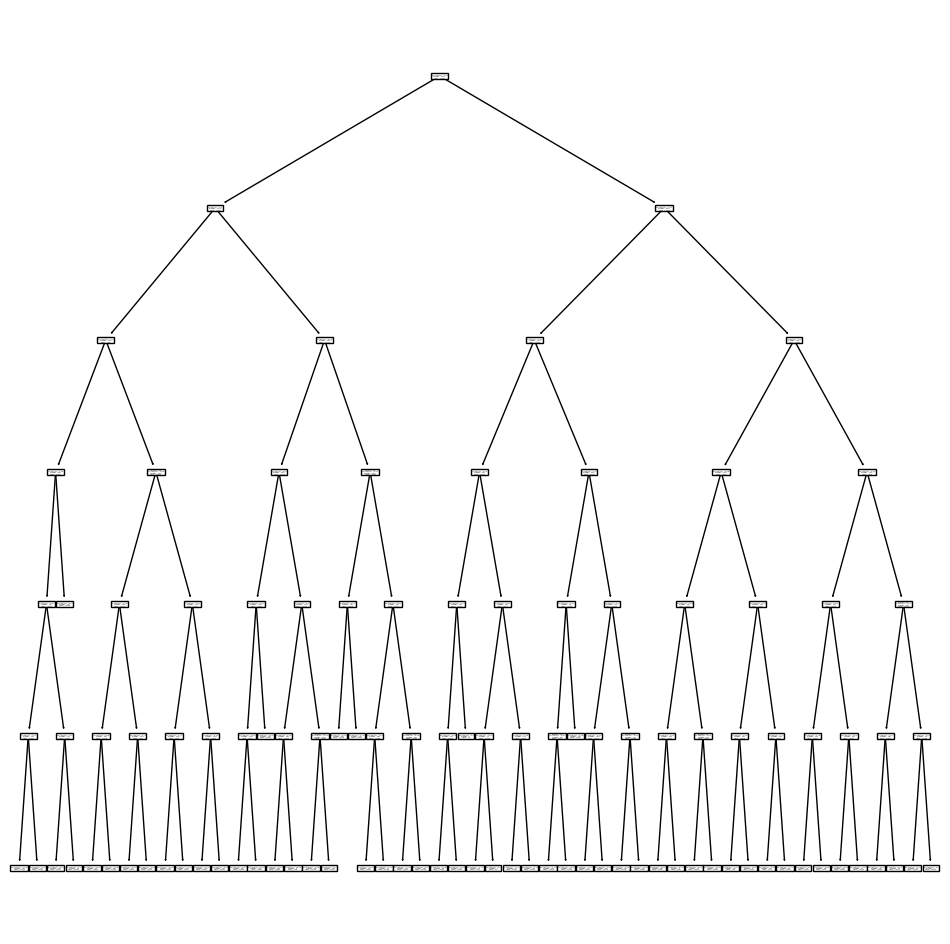

In [100]:
# Print out the best depth that we found from the loop
bestDepth = bestEstimator.get_depth()
print("Best depth is at: " + str(bestDepth))
# Plot the best tree
ax=subplots(figsize=(12,12))[1]
plot_tree(bestEstimator,feature_names=feature_names,ax=ax)

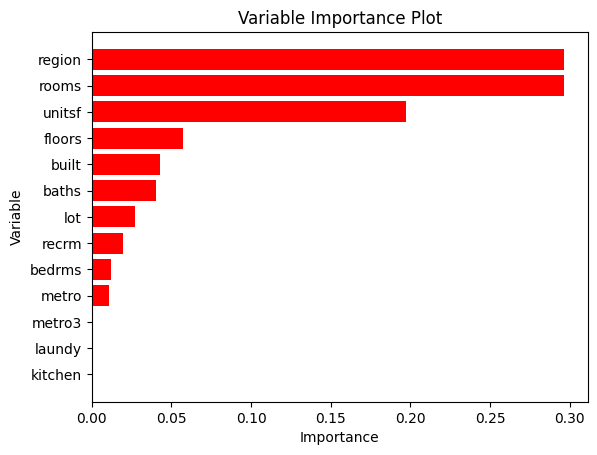

In [107]:
# Initalize the feature importance from the best tree
feature_imp = pd.DataFrame( {'importance':bestEstimator.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=True)

# Sort the names and importances
sorted_names, sorted_imp = zip(*sorted(zip(feature_names, feature_imp['importance']), key=lambda x: x[1]))

# Plot the bar graph
plt.barh(sorted_names, sorted_imp, label='Importance', color='red')
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.title("Variable Importance Plot")
plt.show()

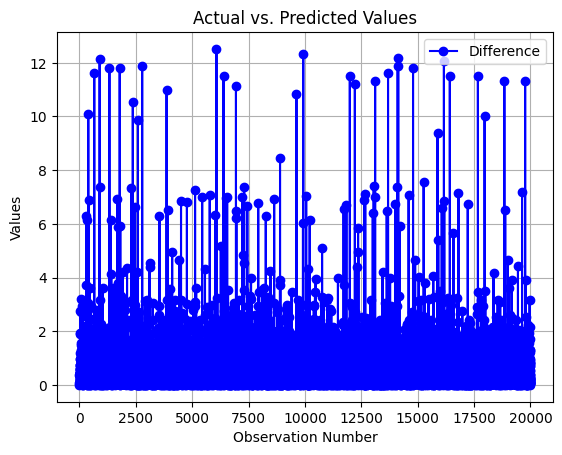

In [102]:
y_pred = bestEstimator.predict(X)

# Create an array of observation numbers
observation_numbers = np.arange(1, len(X) + 1)

# Plot the actual values as a blue line
plt.plot(observation_numbers, abs(houseData["LOGVALUE"]-y_pred), label='Difference', color='blue', marker='o', linestyle='-')

# Plot the predicted values as a red line
# plt.plot(observation_numbers, y_pred, label='Predicted', color='red', marker='x', linestyle='-')

# Add labels and title
plt.xlabel('Observation Number')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [103]:
# Read in test dataset
testData = pd.read_csv('./Econ424_F2023_PC2_test_set_without_response_variable_v1.csv')
modelTest = MS(testData.columns, intercept=False) 

# Format as needed
DTest = modelTest.fit_transform(testData)
feature_names = list(DTest.columns)

# Make Predictions on the Test Set
X_Test = np.asarray(DTest)
Y_Test = bestEstimator.predict(X_Test)


In [104]:
# Specify the file path where you want to save the CSV
csv_file = "./output.csv"

# Use numpy.savetxt to save the array as a CSV file
np.savetxt(csv_file, Y_Test, delimiter="\n", fmt="%f")

In [105]:
print(len(X_Test))
print(Y_Test.size)

10000
10000
